In [1]:
import pandas as pd
import numpy as np

In [2]:
data_dir = '../data/train_test'
selected_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

## Data preprocessing

### Augmenting rows

In [3]:
def add_column_statistics(df, columns, by_column=None, add_std=False):
    df = df.copy()

    if by_column:
        for i in columns:
            df[f'{i}_min_by_fid'] = df.groupby(by_column)[i].transform('min')
            df[f'{i}_max_by_fid'] = df.groupby(by_column)[i].transform('max')
            df[f'{i}_avg_by_fid'] = df.groupby(by_column)[i].transform('mean')

            if add_std:
                df[f'{i}_std_by_fid'] = df.groupby(by_column)[i].transform('std')
    else:
        for i in columns:
            if add_std:
                df[f'{i}_std'] = df.filter(regex = f'^{i}').std(axis = 1)
                
            df[f'{i}_max'] = df.filter(regex = f'^{i}').max(axis = 1)
            df[f'{i}_min'] = df.filter(regex = f'^{i}').min(axis = 1)
            df[f'{i}_avg'] =df.filter(regex = f'^{i}').mean(axis = 1)

    return df
    

def add_column_mappings(df, columns, add_sqrt=False):
    df = df.copy()

    for i in columns:
        
        if add_sqrt:
            df[f'{i}_sqrt'] = np.sqrt(df[i].values)
            
        df[f'{i}_exp'] = np.exp(df[i].values)
        df[f'{i}_^2'] = df[i].values**2
    
    return df

### Add spetral indices

In [4]:
spectral_indices = [
    "NDVI",
    "GNDVI",
    # "EVI",
    "EVI2",
    # "AdvVI", # Advanced vegitation index
    "BSI",
    "SI",
    "NDWI",
    "NDMI",
    "NPCRI",
    "SAVI",
    "MSI",
    "GCI",
    "NBRI",
    "NDSI",
    "NDGI",
    "ARVI",
    "SIPI",
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    "AFRI1.6",
    "AFRI2.1",
    "ARI",
    # "ARVI_paper",
    "ARVI2", # depends on a hyperparameter
    # "ATSAVI" # depends on a hyperparameter
    "AshVI", # Ashburn vegetation index
    "BNDVI",
    "BRI",
    
    "BWDRVI",
    "MCARI1",
    "MCARI2",
    "CCCI",
    "CRI550",
    "CRI700",
    "CVI",
    # "Datt1",
    # "Datt2",
    # "Datt3",
    "DVI",
    "NDI45"
]

def add_spectral_indices(df, phi=1, a=1.22, b=0.03, X=0.08):
    df = df.copy()
    
    df["NDVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"])
    df["GNDVI"] = (df["B08"] - df["B03"]) / (df["B08"] + df["B03"])
    # df["EVI"] = 2.5 * ((df["B08"] - df["B04"]) / ((df["B08"] + 6.0 * df["B04"] - 7.5 * df['B02']) + 1.0))
    df["EVI2"] = 2.4 * (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 1.0)
    # df["AdvVI"] = (df["B08"] * (1 - df["B04"]) * (df["B08"] - df["B04"]))**(1/3)
    df["BSI"] = ((df["B11"] + df["B04"]) - (df["B08"] + df["B02"])) / ((df["B11"] + df["B04"]) + (df["B08"] + df["B02"]))
    df["SI"] = ((1 - df["B02"]) * (1 - df["B03"]) * (1 - df["B04"]))
    df["NDWI"] = (df["B03"] - df["B08"]) / (df["B03"] + df["B08"])
    df["NDMI"] = (df["B08"] - df["B11"]) / (df["B08"] + df["B11"]) 
    df["NPCRI"] = (df["B04"] - df["B02"]) / (df["B04"] + df["B02"]) 
    df["SAVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 0.428) * (1.428)
    df["MSI"] = df["B11"] / df["B08"]
    df["GCI"] = (df["B09"] / df["B03"]) - 1
    df["NBRI"] = (df["B08"] - df["B12"]) / (df["B08"] + df["B12"])
    df["NDSI"] = (df["B03"] - df["B11"]) / (df["B03"] + df["B11"])
    df["NDGI"] = (df["B03"] - df["B04"]) / (df["B03"] + df["B04"]) 
    df["ARVI"] = (df["B08"] - (2 * df["B04"]) + df["B02"]) / (df["B08"] + (2 * df["B04"]) + df["B02"]) 
    df["SIPI"] = (df["B08"] - df["B02"]) / (df["B08"] - df["B04"])
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    df["AFRI1.6"] = (df["B8A"] - 0.66*df["B11"]) / (df["B8A"] + 0.66*df["B11"])
    df["AFRI2.1"] = (df["B8A"] - 0.5*df["B12"]) / (df["B8A"] + 0.5*df["B12"])
    df["ARI"] = ((1/df["B03"]) - (1/df["B05"]))
    # df["ARVI_paper"] = (df["B08"] - (df["B04"] - phi*(df["B02"] - df["B04"]))) / (df["B08"] + (df["B04"] - phi*(df["B02"] - df["B04"])))
    df["ARVI2"] = -0.18 + 1.17 + ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    # df["ATSAVI"] = a*(df["B08"] - a*df["B04"] - b) / (df["B08"] + df["B04"] - a*b + X*(1 + a**2))
    df["AshVI"] = 2*df["B8A"] - df["B04"]
    df["BNDVI"] = (df["B08"] - df["B02"]) / (df["B08"] + df["B02"])
    df["BRI"] = ((1 / df["B03"]) - (1 / df["B05"])) / df["B06"]
    
    df["BWDRVI"] = (0.1*df["B07"] - df["B02"])/(0.1*df["B07"] + df["B02"])
    
    # Chlorophyll absorption ratio index
    df["MCARI"] = ((df["B05"] - df["B04"]) - 0.2*(df["B05"] - df["B03"])) * (df["B05"]/df["B04"])
    df["MCARI1"] = 1.2 * (2.5 * df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])
    df["MCARI2"] = 1.5 * ((2.5 * (df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])) / ((((2*df["B08"] + 1)**2 - (6*df["B08"] - 5*(df["B04"]**(1/2)))) ** (1/2))) - 0.5)
    
    df["CCCI"] = ((df["B08"] - df["B05"]) / (df["B08"] + df["B05"])) / ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    df["CRI550"] = (1 / df["B02"]) - (1 / df["B03"])
    df["CRI700"] = (1 / df["B02"]) - (1 / df["B05"])
    df["CVI"] = (df["B08"] * df["B08"]) / (df["B03"])**2
    # df["Datt1"] = (df["B08"] - df["B05"]) / (df["B08"] + df["B04"])
    # df["Datt2"] = df["B04"] / (df["B03"] * df["B05"])
    # df["Datt3"] = df["B8A"] / (df["B03"] * df["B05"])
    df["DVI"] = 2.4 * df["B08"] - df["B04"]
    df["NDI45"] = (df["B05"] - df["B04"]) / (df["B05"] + df["B04"])
    
    return df

In [5]:
df_train = pd.read_csv(f"{data_dir}/preprocessed/tabular_train.csv")
df_test = pd.read_csv(f"{data_dir}/preprocessed/tabular_test.csv")
df_all = pd.concat([df_train, df_test])

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop
0,44,40,40,42,45,59,70,63,76,13,78,55,1374,1.0
1,44,40,40,42,45,59,70,62,76,13,78,55,1374,1.0
2,44,40,39,42,46,52,58,54,62,16,72,53,3293,1.0
3,44,41,39,43,48,58,65,61,71,16,78,61,3293,1.0
4,44,40,40,44,48,58,65,64,71,16,78,61,3293,1.0


In [6]:
# spectral bands
df_all = add_column_statistics(df_all, selected_bands)
df_all = add_column_mappings(df_all, selected_bands, add_sqrt=True)
df_all = add_column_statistics(df_all, selected_bands, "field_id")

# spectral indices
df_all = add_spectral_indices(df_all)
df_all = add_column_statistics(df_all, spectral_indices)
df_all = add_column_mappings(df_all, spectral_indices)
df_all = add_column_statistics(df_all, spectral_indices, "field_id")

display(df_all.head())

/tmp/ipykernel_53112/1786383380.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_avg_by_fid'] = df.groupby(by_column)[i].transform('mean')
/tmp/ipykernel_53112/1786383380.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_min_by_fid'] = df.groupby(by_column)[i].transform('min')
/tmp/ipykernel_53112/1786383380.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,Datt1_avg_by_fid,Datt2_min_by_fid,Datt2_max_by_fid,Datt2_avg_by_fid,Datt3_min_by_fid,Datt3_max_by_fid,Datt3_avg_by_fid,DVI_min_by_fid,DVI_max_by_fid,DVI_avg_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.163209,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000
1,44,40,40,42,45,59,70,62,76,13,...,0.163209,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000
2,44,40,39,42,46,52,58,54,62,16,...,0.137569,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211
3,44,41,39,43,48,58,65,61,71,16,...,0.137569,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211
4,44,40,40,44,48,58,65,64,71,16,...,0.137569,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211


In [7]:
df_all = df_all.join(df_all.groupby("field_id").size().rename(f'num_pixels_by_fid'), on='field_id')

df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,Datt2_min_by_fid,Datt2_max_by_fid,Datt2_avg_by_fid,Datt3_min_by_fid,Datt3_max_by_fid,Datt3_avg_by_fid,DVI_min_by_fid,DVI_max_by_fid,DVI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000,36
1,44,40,40,42,45,59,70,62,76,13,...,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000,36
2,44,40,39,42,46,52,58,54,62,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19
3,44,41,39,43,48,58,65,61,71,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19
4,44,40,40,44,48,58,65,64,71,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19


In [8]:
tmp = df_all.drop(columns=["crop"])

tmp.loc[:, tmp.isna().any()]

""
0
1
2
3
4
...
49313
49314
49315
49316


## Feature selection

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_all = df_all.reset_index(drop=True)
df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,Datt2_min_by_fid,Datt2_max_by_fid,Datt2_avg_by_fid,Datt3_min_by_fid,Datt3_max_by_fid,Datt3_avg_by_fid,DVI_min_by_fid,DVI_max_by_fid,DVI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000,36
1,44,40,40,42,45,59,70,62,76,13,...,0.021850,0.025063,0.023205,0.037994,0.047619,0.040345,104.8,115.6,109.000000,36
2,44,40,39,42,46,52,58,54,62,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19
3,44,41,39,43,48,58,65,61,71,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19
4,44,40,40,44,48,58,65,64,71,16,...,0.021739,0.024457,0.023022,0.033542,0.040541,0.036470,87.6,115.6,106.684211,19


In [11]:
X_train = df_all[~df_all["crop"].isnull()]
df_test = df_all[df_all["crop"].isnull()]
y_train = X_train["crop"]

X_train = X_train.drop(columns=["field_id", "crop"])
X_test = df_test.drop(columns=["field_id", "crop"])

In [12]:
X_train.shape, y_train.shape, X_test.shape

((188228, 427), (188228,), (49318, 427))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 5, shuffle = True)

In [14]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_class_weight

In [15]:
label_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

In [16]:
# cb_pi --> catboost_permutation_importance\n",
cb_pi = CatBoostClassifier(n_estimators = 1400, learning_rate = 0.03, random_state = 11, task_type = "GPU")
cb_pi.fit(X_train, y_train)

0:	learn: 2.4140423	total: 98.4ms	remaining: 2m 17s
1:	learn: 2.2947319	total: 162ms	remaining: 1m 53s
2:	learn: 2.1958001	total: 226ms	remaining: 1m 45s
3:	learn: 2.1117803	total: 285ms	remaining: 1m 39s
4:	learn: 2.0367495	total: 349ms	remaining: 1m 37s
5:	learn: 1.9713412	total: 411ms	remaining: 1m 35s
6:	learn: 1.9122011	total: 479ms	remaining: 1m 35s
7:	learn: 1.8592428	total: 537ms	remaining: 1m 33s
8:	learn: 1.8113949	total: 599ms	remaining: 1m 32s
9:	learn: 1.7665825	total: 663ms	remaining: 1m 32s
10:	learn: 1.7252184	total: 729ms	remaining: 1m 32s
11:	learn: 1.6883911	total: 792ms	remaining: 1m 31s
12:	learn: 1.6538076	total: 851ms	remaining: 1m 30s
13:	learn: 1.6203289	total: 911ms	remaining: 1m 30s
14:	learn: 1.5897498	total: 973ms	remaining: 1m 29s
15:	learn: 1.5613291	total: 1.03s	remaining: 1m 29s
16:	learn: 1.5339041	total: 1.09s	remaining: 1m 28s
17:	learn: 1.5086946	total: 1.15s	remaining: 1m 28s
18:	learn: 1.4846433	total: 1.21s	remaining: 1m 28s
19:	learn: 1.4618851	

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
pi = PermutationImportance(cb_pi, random_state = 90, n_iter = 5)
pi.fit(X_val, y_val)
eli5.show_weights(pi, feature_names = X_train.columns.tolist(), top = None)

Weight,Feature
0.0412 ± 0.0010,num_pixels_by_fid
0.0284 ± 0.0011,NDSI_min_by_fid
0.0140 ± 0.0002,CCCI_avg_by_fid
0.0086 ± 0.0004,Datt2_max_by_fid
0.0070 ± 0.0006,NDGI_min_by_fid
0.0068 ± 0.0006,CCCI_max_by_fid
0.0062 ± 0.0005,BRI_max_by_fid
0.0061 ± 0.0004,CRI700_max_by_fid
0.0057 ± 0.0007,BRI_avg_by_fid
0.0055 ± 0.0005,CCCI_min_by_fid


In [19]:
pi_results = eli5.formatters.as_dataframe.explain_weights_df(pi, feature_names = X_train.columns.tolist())
# feature importance weigth threshold is 0\n",
low_importance = pi_results[pi_results.weight <= 0].feature.values
low_importance

array(['GNDVI_min', 'CVI', 'Datt1', 'Datt2', 'Datt3', 'DVI', 'NDVI_max',
       'NDVI_min', 'NDVI_avg', 'GNDVI_max', 'SI_avg', 'SIPI', 'CRI550',
       'GNDVI_avg', 'EVI2_max', 'EVI2_min', 'EVI2_avg', 'SI_min',
       'BSI_max', 'SI_max', 'BSI_avg', 'NDWI_max', 'CRI700', 'BSI_min',
       'ARVI', 'MCARI2', 'NDGI', 'NDSI', 'NBRI', 'GCI', 'MSI', 'AFRI2.1',
       'SAVI', 'NPCRI', 'NDMI', 'NDWI', 'SI', 'BSI', 'EVI2', 'GNDVI',
       'ARVI2', 'NDVI', 'AshVI', 'BNDVI', 'BRI', 'BWDRVI', 'MCARI1',
       'CCCI', 'B8A_min', 'B12_^2', 'B07_max', 'B04_avg', 'B05_max',
       'B05_min', 'B05_avg', 'B06_max', 'B06_min', 'B06_avg', 'B07_min',
       'B09_avg', 'B07_avg', 'B08_max', 'B08_min', 'B08_avg', 'B8A_max',
       'NDWI_avg', 'B8A_avg', 'B04_min', 'B04_max', 'B03_avg', 'B03_min',
       'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'B02_max', 'B02_min', 'B02_avg', 'B03_max',
       'B09_min', 'B11_max', 'B12_exp', 'B8A_exp', 'B07_sqrt', 'B07_exp',
      

In [20]:
features_to_drop = low_importance

In [21]:
X_train_curated = X_train.drop(columns = features_to_drop)
X_test_curated = X_test.drop(columns = features_to_drop)

X_train_curated.shape, X_test_curated.shape

((150582, 128), (49318, 128))

## Cross Validation

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

cb = CatBoostClassifier(n_estimators = 1500, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU")

# Use "class_weights = label_weights" for cross validation
cb2 = CatBoostClassifier(n_estimators = 1100, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU", class_weights = label_weights)

lda = LinearDiscriminantAnalysis()
bc = BaggingClassifier(base_estimator = lda, n_estimators = 30, random_state = 0)
      

In [23]:
# Catboost without weights
cv1 = cross_val_predict(cb, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4147973	total: 29.5ms	remaining: 44.2s
1:	learn: 2.2980453	total: 56ms	remaining: 42s
2:	learn: 2.2008750	total: 80.6ms	remaining: 40.2s
3:	learn: 2.1145352	total: 105ms	remaining: 39.1s
4:	learn: 2.0390919	total: 130ms	remaining: 38.9s
5:	learn: 1.9732667	total: 156ms	remaining: 38.9s
6:	learn: 1.9140421	total: 183ms	remaining: 39s
7:	learn: 1.8604905	total: 206ms	remaining: 38.5s
8:	learn: 1.8120931	total: 234ms	remaining: 38.7s
9:	learn: 1.7674471	total: 261ms	remaining: 38.8s
10:	learn: 1.7264794	total: 286ms	remaining: 38.6s
11:	learn: 1.6889928	total: 311ms	remaining: 38.5s
12:	learn: 1.6539672	total: 335ms	remaining: 38.3s
13:	learn: 1.6212847	total: 359ms	remaining: 38.1s
14:	learn: 1.5900303	total: 384ms	remaining: 38s
15:	learn: 1.5618979	total: 409ms	remaining: 37.9s
16:	learn: 1.5349574	total: 432ms	remaining: 37.7s
17:	learn: 1.5084470	total: 456ms	remaining: 37.6s
18:	learn: 1.4842087	total: 480ms	remaining: 37.4s
19:	learn: 1.4615948	total: 501ms	remaining: 3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s


0:	learn: 2.4144368	total: 23.9ms	remaining: 35.9s
1:	learn: 2.2949168	total: 47.2ms	remaining: 35.3s
2:	learn: 2.1983258	total: 68.7ms	remaining: 34.3s
3:	learn: 2.1128799	total: 91.4ms	remaining: 34.2s
4:	learn: 2.0382900	total: 113ms	remaining: 33.9s
5:	learn: 1.9735425	total: 136ms	remaining: 34s
6:	learn: 1.9145497	total: 161ms	remaining: 34.3s
7:	learn: 1.8613538	total: 182ms	remaining: 34s
8:	learn: 1.8136493	total: 204ms	remaining: 33.8s
9:	learn: 1.7691654	total: 226ms	remaining: 33.7s
10:	learn: 1.7285321	total: 248ms	remaining: 33.6s
11:	learn: 1.6906989	total: 273ms	remaining: 33.8s
12:	learn: 1.6561029	total: 294ms	remaining: 33.6s
13:	learn: 1.6231312	total: 317ms	remaining: 33.7s
14:	learn: 1.5923527	total: 340ms	remaining: 33.6s
15:	learn: 1.5634169	total: 363ms	remaining: 33.7s
16:	learn: 1.5363534	total: 386ms	remaining: 33.7s
17:	learn: 1.5100698	total: 411ms	remaining: 33.8s
18:	learn: 1.4859140	total: 434ms	remaining: 33.8s
19:	learn: 1.4626241	total: 458ms	remaini

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


0:	learn: 2.4155350	total: 23.9ms	remaining: 35.8s
1:	learn: 2.2988390	total: 46.5ms	remaining: 34.8s
2:	learn: 2.2005869	total: 68.1ms	remaining: 34s
3:	learn: 2.1146603	total: 90.4ms	remaining: 33.8s
4:	learn: 2.0404225	total: 112ms	remaining: 33.5s
5:	learn: 1.9742780	total: 136ms	remaining: 33.9s
6:	learn: 1.9147654	total: 161ms	remaining: 34.3s
7:	learn: 1.8611376	total: 186ms	remaining: 34.6s
8:	learn: 1.8117270	total: 208ms	remaining: 34.4s
9:	learn: 1.7672929	total: 229ms	remaining: 34.2s
10:	learn: 1.7267049	total: 250ms	remaining: 33.9s
11:	learn: 1.6890057	total: 273ms	remaining: 33.9s
12:	learn: 1.6545038	total: 295ms	remaining: 33.8s
13:	learn: 1.6214004	total: 318ms	remaining: 33.8s
14:	learn: 1.5907739	total: 342ms	remaining: 33.8s
15:	learn: 1.5616088	total: 365ms	remaining: 33.9s
16:	learn: 1.5342626	total: 389ms	remaining: 33.9s
17:	learn: 1.5088274	total: 412ms	remaining: 33.9s
18:	learn: 1.4847965	total: 436ms	remaining: 34s
19:	learn: 1.4615282	total: 460ms	remaini

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


0:	learn: 2.4139490	total: 25.5ms	remaining: 38.2s
1:	learn: 2.2947561	total: 48.4ms	remaining: 36.2s
2:	learn: 2.1967887	total: 69.7ms	remaining: 34.8s
3:	learn: 2.1111300	total: 92.1ms	remaining: 34.5s
4:	learn: 2.0366307	total: 115ms	remaining: 34.3s
5:	learn: 1.9712076	total: 138ms	remaining: 34.4s
6:	learn: 1.9128761	total: 163ms	remaining: 34.7s
7:	learn: 1.8596709	total: 183ms	remaining: 34.2s
8:	learn: 1.8109546	total: 206ms	remaining: 34.1s
9:	learn: 1.7665312	total: 228ms	remaining: 34s
10:	learn: 1.7262507	total: 250ms	remaining: 33.8s
11:	learn: 1.6884120	total: 274ms	remaining: 33.9s
12:	learn: 1.6539594	total: 295ms	remaining: 33.7s
13:	learn: 1.6209305	total: 317ms	remaining: 33.6s
14:	learn: 1.5902725	total: 340ms	remaining: 33.6s
15:	learn: 1.5611730	total: 363ms	remaining: 33.6s
16:	learn: 1.5344461	total: 385ms	remaining: 33.6s
17:	learn: 1.5089666	total: 408ms	remaining: 33.6s
18:	learn: 1.4850473	total: 431ms	remaining: 33.6s
19:	learn: 1.4622272	total: 452ms	remai

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s


0:	learn: 2.4152523	total: 25.6ms	remaining: 38.4s
1:	learn: 2.2959544	total: 47.8ms	remaining: 35.8s
2:	learn: 2.1978177	total: 68ms	remaining: 33.9s
3:	learn: 2.1130599	total: 89.6ms	remaining: 33.5s
4:	learn: 2.0383184	total: 113ms	remaining: 33.7s
5:	learn: 1.9729338	total: 136ms	remaining: 33.8s
6:	learn: 1.9143315	total: 158ms	remaining: 33.7s
7:	learn: 1.8610072	total: 180ms	remaining: 33.6s
8:	learn: 1.8125337	total: 203ms	remaining: 33.6s
9:	learn: 1.7683038	total: 225ms	remaining: 33.6s
10:	learn: 1.7275130	total: 247ms	remaining: 33.4s
11:	learn: 1.6897525	total: 270ms	remaining: 33.5s
12:	learn: 1.6551460	total: 291ms	remaining: 33.3s
13:	learn: 1.6223080	total: 313ms	remaining: 33.3s
14:	learn: 1.5918269	total: 337ms	remaining: 33.4s
15:	learn: 1.5630968	total: 359ms	remaining: 33.3s
16:	learn: 1.5356728	total: 384ms	remaining: 33.5s
17:	learn: 1.5100454	total: 407ms	remaining: 33.5s
18:	learn: 1.4862176	total: 430ms	remaining: 33.5s
19:	learn: 1.4636907	total: 450ms	remai

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [24]:
# Catboost with weights
cv2 = cross_val_predict(cb2, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4623620	total: 28.2ms	remaining: 30.9s
1:	learn: 2.3804895	total: 53.3ms	remaining: 29.3s
2:	learn: 2.3141121	total: 76.9ms	remaining: 28.1s
3:	learn: 2.2559340	total: 99.8ms	remaining: 27.3s
4:	learn: 2.2051981	total: 123ms	remaining: 26.9s
5:	learn: 2.1495252	total: 150ms	remaining: 27.3s
6:	learn: 2.1024310	total: 172ms	remaining: 26.9s
7:	learn: 2.0615681	total: 196ms	remaining: 26.7s
8:	learn: 2.0216829	total: 219ms	remaining: 26.5s
9:	learn: 1.9791195	total: 243ms	remaining: 26.4s
10:	learn: 1.9422313	total: 269ms	remaining: 26.6s
11:	learn: 1.9023294	total: 294ms	remaining: 26.7s
12:	learn: 1.8722191	total: 320ms	remaining: 26.8s
13:	learn: 1.8365425	total: 344ms	remaining: 26.7s
14:	learn: 1.8005797	total: 371ms	remaining: 26.8s
15:	learn: 1.7638657	total: 402ms	remaining: 27.2s
16:	learn: 1.7315246	total: 432ms	remaining: 27.5s
17:	learn: 1.7059662	total: 464ms	remaining: 27.9s
18:	learn: 1.6808526	total: 489ms	remaining: 27.8s
19:	learn: 1.6583030	total: 513ms	rem

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


0:	learn: 2.4634714	total: 27.7ms	remaining: 30.4s
1:	learn: 2.3810818	total: 54.1ms	remaining: 29.7s
2:	learn: 2.3110354	total: 80.1ms	remaining: 29.3s
3:	learn: 2.2517562	total: 103ms	remaining: 28.2s
4:	learn: 2.1962204	total: 126ms	remaining: 27.6s
5:	learn: 2.1422268	total: 152ms	remaining: 27.6s
6:	learn: 2.0879576	total: 178ms	remaining: 27.8s
7:	learn: 2.0460917	total: 202ms	remaining: 27.6s
8:	learn: 2.0062366	total: 225ms	remaining: 27.3s
9:	learn: 1.9677950	total: 248ms	remaining: 27.1s
10:	learn: 1.9312590	total: 274ms	remaining: 27.2s
11:	learn: 1.8980347	total: 299ms	remaining: 27.1s
12:	learn: 1.8575853	total: 324ms	remaining: 27.1s
13:	learn: 1.8240179	total: 349ms	remaining: 27.1s
14:	learn: 1.7876936	total: 376ms	remaining: 27.2s
15:	learn: 1.7528636	total: 403ms	remaining: 27.3s
16:	learn: 1.7260746	total: 426ms	remaining: 27.1s
17:	learn: 1.6988191	total: 450ms	remaining: 27.1s
18:	learn: 1.6742306	total: 473ms	remaining: 26.9s
19:	learn: 1.6418717	total: 500ms	rema

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s remaining:    0.0s


0:	learn: 2.4641829	total: 28.2ms	remaining: 31s
1:	learn: 2.3828291	total: 53.5ms	remaining: 29.4s
2:	learn: 2.3167769	total: 77.3ms	remaining: 28.3s
3:	learn: 2.2579164	total: 100ms	remaining: 27.4s
4:	learn: 2.2062376	total: 123ms	remaining: 26.8s
5:	learn: 2.1510782	total: 149ms	remaining: 27.2s
6:	learn: 2.0959885	total: 175ms	remaining: 27.3s
7:	learn: 2.0548124	total: 198ms	remaining: 27s
8:	learn: 2.0175734	total: 220ms	remaining: 26.7s
9:	learn: 1.9809016	total: 245ms	remaining: 26.7s
10:	learn: 1.9447891	total: 269ms	remaining: 26.6s
11:	learn: 1.9038654	total: 295ms	remaining: 26.7s
12:	learn: 1.8674506	total: 320ms	remaining: 26.7s
13:	learn: 1.8366060	total: 345ms	remaining: 26.8s
14:	learn: 1.8006830	total: 371ms	remaining: 26.9s
15:	learn: 1.7650011	total: 399ms	remaining: 27s
16:	learn: 1.7366474	total: 423ms	remaining: 27s
17:	learn: 1.7135067	total: 447ms	remaining: 26.9s
18:	learn: 1.6787327	total: 474ms	remaining: 27s
19:	learn: 1.6514299	total: 499ms	remaining: 26.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


0:	learn: 2.4615364	total: 27.7ms	remaining: 30.5s
1:	learn: 2.3818715	total: 52.9ms	remaining: 29s
2:	learn: 2.3189192	total: 74.9ms	remaining: 27.4s
3:	learn: 2.2566114	total: 98.9ms	remaining: 27.1s
4:	learn: 2.1994067	total: 122ms	remaining: 26.8s
5:	learn: 2.1426850	total: 149ms	remaining: 27.1s
6:	learn: 2.0939724	total: 174ms	remaining: 27.1s
7:	learn: 2.0511661	total: 198ms	remaining: 27s
8:	learn: 2.0109173	total: 220ms	remaining: 26.7s
9:	learn: 1.9724398	total: 243ms	remaining: 26.5s
10:	learn: 1.9344951	total: 267ms	remaining: 26.5s
11:	learn: 1.9014186	total: 292ms	remaining: 26.5s
12:	learn: 1.8581712	total: 319ms	remaining: 26.7s
13:	learn: 1.8288923	total: 345ms	remaining: 26.7s
14:	learn: 1.7962324	total: 371ms	remaining: 26.8s
15:	learn: 1.7594893	total: 397ms	remaining: 26.9s
16:	learn: 1.7327276	total: 423ms	remaining: 26.9s
17:	learn: 1.7061456	total: 445ms	remaining: 26.8s
18:	learn: 1.6779595	total: 473ms	remaining: 26.9s
19:	learn: 1.6523583	total: 497ms	remaini

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


0:	learn: 2.4760027	total: 23.9ms	remaining: 26.2s
1:	learn: 2.3872121	total: 51.1ms	remaining: 28.1s
2:	learn: 2.3219486	total: 73.7ms	remaining: 26.9s
3:	learn: 2.2579667	total: 98ms	remaining: 26.9s
4:	learn: 2.2025950	total: 121ms	remaining: 26.5s
5:	learn: 2.1454745	total: 148ms	remaining: 27s
6:	learn: 2.0958085	total: 172ms	remaining: 26.9s
7:	learn: 2.0543656	total: 197ms	remaining: 26.9s
8:	learn: 2.0162595	total: 220ms	remaining: 26.6s
9:	learn: 1.9773363	total: 244ms	remaining: 26.6s
10:	learn: 1.9373941	total: 269ms	remaining: 26.6s
11:	learn: 1.9058939	total: 293ms	remaining: 26.6s
12:	learn: 1.8705853	total: 316ms	remaining: 26.5s
13:	learn: 1.8410915	total: 342ms	remaining: 26.5s
14:	learn: 1.8062473	total: 367ms	remaining: 26.6s
15:	learn: 1.7721496	total: 394ms	remaining: 26.7s
16:	learn: 1.7490094	total: 417ms	remaining: 26.6s
17:	learn: 1.7231262	total: 440ms	remaining: 26.5s
18:	learn: 1.6936479	total: 467ms	remaining: 26.6s
19:	learn: 1.6687241	total: 491ms	remaini

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [25]:
# Bagged LDA
cv3 = cross_val_predict(bc, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.3min finished


## Dertermining weights

In [26]:
def determine_weights(cvs, y):
    # Code to determine weights
    scores = []

    for w in range(0, 101):
        w = w / 100.
        #  two cross-validation results of choice should be imputed to determine appropriate weights
        scores.append(log_loss(y, (w * cvs[0]) + ((1 - w) * cvs[1])))

    best_score = min(scores)
    weight = scores.index(best_score) / 100.

    return (weight, best_score)

In [27]:
determine_weights([cv1, cv2], y_train)

(1.0, 0.1737339703643138)

In [28]:
determine_weights([cv1, cv3], y_train)

(1.0, 0.1737339703643138)

In [29]:
determine_weights([cv2, cv3], y_train)

(1.0, 0.45437252542554607)

## Training

In [30]:
cb.fit(X_train_curated, y_train)
cb2.fit(X_train_curated, y_train)
bc.fit(X_train_curated, y_train)

0:	learn: 2.4141925	total: 32ms	remaining: 48s
1:	learn: 2.2971271	total: 61.7ms	remaining: 46.2s
2:	learn: 2.1991602	total: 88.5ms	remaining: 44.2s
3:	learn: 2.1141992	total: 119ms	remaining: 44.5s
4:	learn: 2.0395048	total: 145ms	remaining: 43.5s
5:	learn: 1.9730728	total: 175ms	remaining: 43.5s
6:	learn: 1.9148583	total: 202ms	remaining: 43s
7:	learn: 1.8621480	total: 226ms	remaining: 42.2s
8:	learn: 1.8138027	total: 255ms	remaining: 42.3s
9:	learn: 1.7692721	total: 285ms	remaining: 42.5s
10:	learn: 1.7284915	total: 312ms	remaining: 42.2s
11:	learn: 1.6913034	total: 339ms	remaining: 42.1s
12:	learn: 1.6568804	total: 363ms	remaining: 41.6s
13:	learn: 1.6237474	total: 390ms	remaining: 41.3s
14:	learn: 1.5933303	total: 415ms	remaining: 41.1s
15:	learn: 1.5643247	total: 440ms	remaining: 40.8s
16:	learn: 1.5365257	total: 467ms	remaining: 40.7s
17:	learn: 1.5107819	total: 493ms	remaining: 40.6s
18:	learn: 1.4866220	total: 518ms	remaining: 40.4s
19:	learn: 1.4643822	total: 540ms	remaining:

BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=30,
                  random_state=0)

## Inference

In [31]:
test_preds_1 = cb.predict_proba(X_test_curated)
test_preds_2 = cb2.predict_proba(X_test_curated)
test_preds_3 = bc.predict_proba(X_test_curated)

### Weighted Average

In [32]:
w1, w2 = 0.80, 0.90

# Level 1
test_preds = (w1 * test_preds_1) + ((1 - w1) * test_preds_2)

# Level 2
test_preds = (w2 * test_preds) + ((1 - w2) * test_preds_3)

In [33]:
test_preds.shape

(49318, 13)

In [34]:
test_preds = pd.DataFrame(test_preds)
test_preds = pd.concat(
    [
        df_test["field_id"].reset_index(drop=True),
        test_preds.reset_index(drop=True)
    ],
    axis=1
)

display(test_preds.head())

,field_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5407,0.236159,0.591037,0.089023,0.025683,0.000184,0.006569,0.047646,0.003172,0.000142,0.000039,0.000038,0.000040,0.000270
1,5407,0.236156,0.591022,0.089039,0.025683,0.000184,0.006569,0.047646,0.003172,0.000143,0.000039,0.000038,0.000040,0.000270
2,5407,0.236157,0.591024,0.089036,0.025683,0.000184,0.006569,0.047646,0.003172,0.000143,0.000039,0.000038,0.000040,0.000270
3,5407,0.236151,0.590984,0.089082,0.025683,0.000184,0.006569,0.047646,0.003172,0.000144,0.000039,0.000038,0.000040,0.000270
4,5407,0.238336,0.590592,0.089079,0.024926,0.000184,0.006359,0.046853,0.003140,0.000146,0.000038,0.000037,0.000038,0.000271


In [35]:
test_preds = test_preds.groupby("field_id")[list(range(13))].mean()
display(test_preds.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12
field_id,,,,,,,,,,,,,
11,0.187527,0.317247,0.019543,0.085560,0.004749,0.382455,0.000234,1.536923e-03,0.000088,0.000093,0.000235,0.000160,0.000572
13,0.610587,0.142572,0.010083,0.214052,0.002478,0.014344,0.001571,4.428318e-05,0.000821,0.000109,0.000374,0.001125,0.001840
19,0.361931,0.325288,0.035318,0.052220,0.001429,0.220251,0.000329,1.728911e-05,0.000264,0.002702,0.000108,0.000131,0.000013
21,0.067462,0.215315,0.019778,0.435569,0.002240,0.252954,0.001912,2.494142e-04,0.000768,0.000085,0.002384,0.001042,0.000242
25,0.110798,0.020834,0.096258,0.770324,0.000206,0.001309,0.000045,9.772282e-07,0.000157,0.000012,0.000003,0.000049,0.000005


### Checking predictions

<BarContainer object of 9 artists>

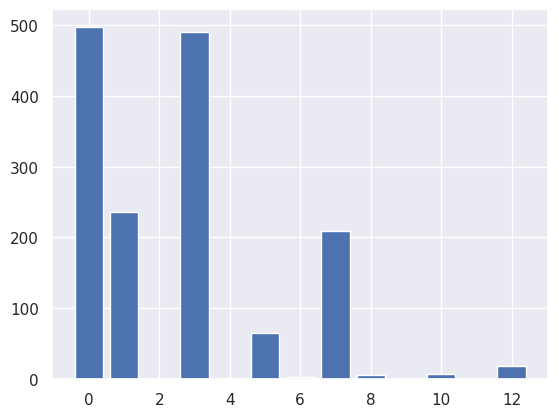

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.bar(*np.unique(test_preds.values.argmax(axis=-1), return_counts=True))

## Submission

In [37]:
submission = pd.read_csv(f"{data_dir}/SampleSubmission.csv")
display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
submission["Wheat"] = test_preds[0].values
submission["Mustard"] = test_preds[1].values
submission["Lentil"] = test_preds[2].values
submission["No Crop"] = test_preds[3].values
submission["Green pea"] = test_preds[4].values
submission["Sugarcane"] = test_preds[5].values
submission["Garlic"] = test_preds[6].values
submission["Gram"] = test_preds[7].values
submission["Maize"] = test_preds[8].values
submission["Coriander"] = test_preds[9].values
submission["Potato"] = test_preds[10].values
submission["Bersem"] = test_preds[11].values
submission["Rice"] = test_preds[12].values

display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0.187527,0.317247,0.019543,0.085560,0.004749,0.382455,0.000234,0.000088,1.536923e-03,0.000093,0.000235,0.000160,0.000572
1,13,0.610587,0.142572,0.010083,0.214052,0.002478,0.014344,0.001571,0.000821,4.428318e-05,0.000109,0.000374,0.001125,0.001840
2,19,0.361931,0.325288,0.035318,0.052220,0.001429,0.220251,0.000329,0.000264,1.728911e-05,0.002702,0.000108,0.000131,0.000013
3,21,0.067462,0.215315,0.019778,0.435569,0.002240,0.252954,0.001912,0.000768,2.494142e-04,0.000085,0.002384,0.001042,0.000242
4,25,0.110798,0.020834,0.096258,0.770324,0.000206,0.001309,0.000045,0.000157,9.772282e-07,0.000012,0.000003,0.000049,0.000005


In [39]:
submission.to_csv(f"{data_dir}/submission.csv", index = False)